<a href="https://colab.research.google.com/github/mahdi943/Transfer_learning/blob/master/Transfer_learning_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1) Dataset
[**CelebA**](https://www.cs.toronto.edu/~kriz/cifar.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. 

Keras is a library that we will use especially for deep learning, but also with basic neural network functionality of course. 
You may find the necessary function references here: 

http://scikit-learn.org/stable/supervised_learning.html
https://keras.io/api/
https://keras.io/api/applications/



## 2) Load training dataset

*  Read from Keras library.



In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score


import keras
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.layers import Dropout
from keras.regularizers import l2
from keras.regularizers import l1
np.random.seed(5)
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os

In [ ]:
# import the necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
% matplotlib inline
from keras.preprocessing.image import load_img,img_to_array,array_to_img,save_img

In [ ]:
IMG_SIZE = (128,128)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/Deep learning/dataset/celeba_30k.csv') # enter the file path on your drive for the csv file
data.head()

,image_id,Male,Blond_Hair,Eyeglasses,Wearing_Earrings,Bangs,Young,Smiling,Heavy_Makeup,Straight_Hair,Black_Hair
0,000001.jpg,0,0,0,1,0,1,1,1,1,0
1,000002.jpg,0,0,0,0,0,1,1,0,0,0
2,000003.jpg,1,0,0,0,0,1,0,0,0,0
3,000004.jpg,0,0,0,1,0,1,0,0,1,0
4,000005.jpg,0,0,0,0,0,1,0,1,0,0


In [ ]:
gender_data = data[['image_id', 'Male']].copy()
gender_data.head()

,image_id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
#this will extract the contents of the zip file into a folder named data
#do not extract the zip into your google drive (i.e don't use drive/My Drive in the right path since it slows down the process)
#only change the left path

!unzip "/content/drive/MyDrive/Colab-Notebooks/Deep learning/dataset/celeba_30k.zip" -d "/content/data"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
  
first_image_path = os.path.join("/content/data/celeba_30k/", gender_data.loc[0,"image_id"])
img = Image.open(first_image_path) 

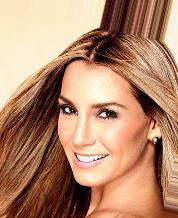

In [ ]:
img

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as its memory usage, distribution of labels, etc.


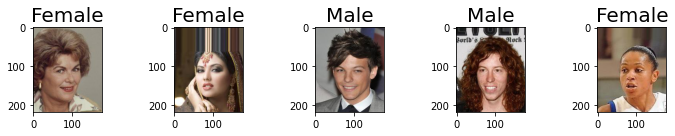

In [ ]:
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator, load_img


data_path = "/content/data/celeba_30k/"

def plot_images (df, num_row = 1, num_col = 5):

    plt.rcParams['axes.grid'] = False
    fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

    for i in range(5):
        random_num = np.random.randint(len(df))
        ax = axes[ i%num_col]
        image_path = os.path.join(data_path, df.loc[random_num,'image_id'])
        image = load_img(image_path)

        ax.imshow(image)

        if df.loc[random_num, 'Male'] == 1:
            plot_title = "Male"
        else:
            plot_title = "Female"
        ax.set_title(plot_title ,fontsize=20)
    plt.tight_layout()

plot_images(gender_data)

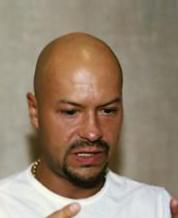

image_id    001669.jpg
Male                 1
Name: 1668, dtype: object


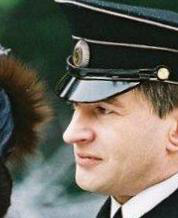

image_id    026068.jpg
Male                 1
Name: 26067, dtype: object


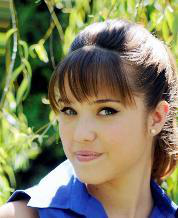

image_id    012467.jpg
Male                 0
Name: 12466, dtype: object


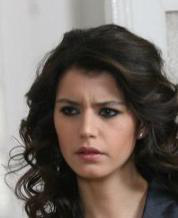

image_id    014944.jpg
Male                 0
Name: 14943, dtype: object


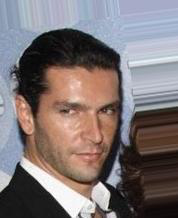

image_id    000979.jpg
Male                 1
Name: 978, dtype: object


In [ ]:
from  random import randint

for index in range(5):
  index = randint(0, 30000)
  image_path = os.path.join("/content/data/celeba_30k/", gender_data.loc[index,"image_id"])
  img = Image.open(image_path)
  display(img)
  print(gender_data.loc[index])

- Display statistics about the dataset, such as its memory usage, distribution of labels, etc.

In [ ]:
# Memory usage

total_mem_size = 0
for index in range(30000):
  image_path = os.path.join("/content/data/celeba_30k/", gender_data.loc[index,"image_id"])
  img = Image.open(image_path)
  total_mem_size += np.array(img).nbytes

total_mem_size = round((total_mem_size/1048576), 2)
print('Memory usage:', total_mem_size, 'MB')




Memory usage: 3330.57 MB


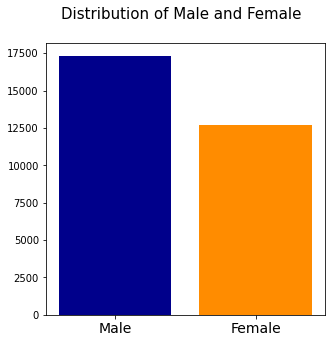

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
plt.suptitle('Distribution of Male and Female', fontsize=15)
ax.bar(gender_data['Male'].value_counts().index, 
       gender_data['Male'].value_counts().values,
       color = ['darkblue', 'darkorange'])
ax.set_xticks(range(0, 2))
ax.set_xticklabels(['Male','Female'], fontsize = 14);

##4) Split the dataset as train (also called development) (80%) and validation (10%) and test (10%) set. You'll tune the hyperparameters using the validation set and evaulate the model on the unseen test set. 

In [ ]:
gender_data["Male"] = gender_data["Male"].replace({0: 'Female', 1: 'Male'}) 

In [ ]:
# Split 80-10-10
from sklearn.model_selection import train_test_split 
train_df, val_df = train_test_split(gender_data, test_size=0.1, random_state=42, shuffle = True)
train_df, test_df = train_test_split(train_df, test_size=1/9, random_state=42, shuffle = True) #since 0.9 * (1/9) = 0.1


In [ ]:
data_path = "/content/data/celeba_30k" #where you extracted the zip file
total_train = train_df.shape[0]
total_validate = val_df.shape[0]
batch_size= 16

#create the test_generator accordingly

from keras.preprocessing.image import ImageDataGenerator, load_img


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=70,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) #augmentations for training set... https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_generator = train_datagen.flow_from_dataframe(    
    train_df, 
    data_path, 
    x_col='image_id',
    y_col='Male',
    class_mode='categorical',
    target_size=(224,224), #this will resize the image, you can change the size
    batch_size=batch_size,
    shuffle=True
   
)


val_datagen = ImageDataGenerator(rescale=1./255) #augmentations for validation set
val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    data_path, 
    x_col='image_id',
    y_col='Male',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True

)

Found 24000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


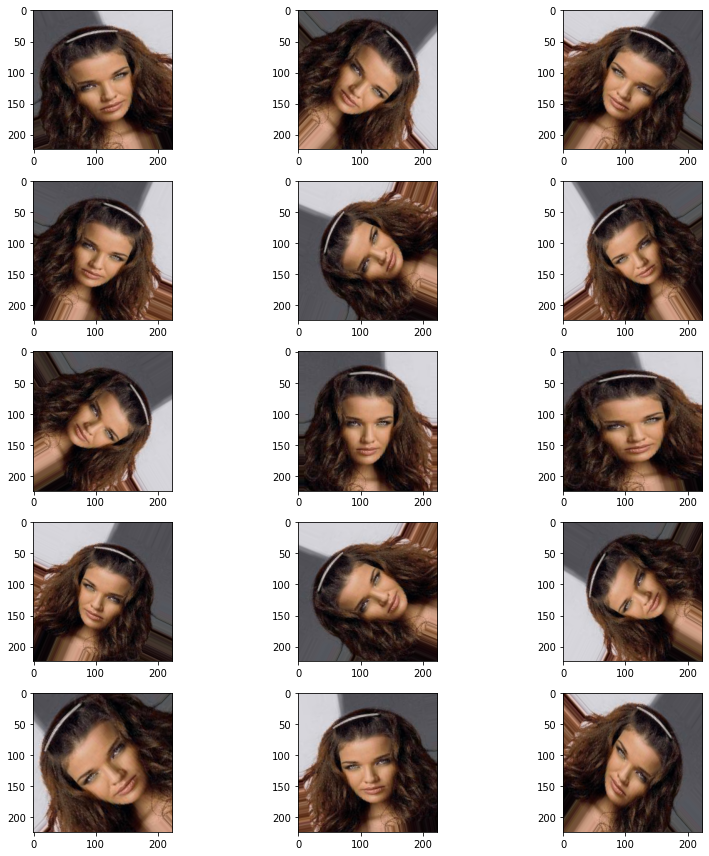

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    data_path, 
    x_col='image_id',
    y_col='Male',
    target_size=(224,224),
    class_mode='categorical',
    batch_size = 1
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

##4) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 model. This is pre-trained on ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

First, you need to pick which layer of VGG-16 you will use for feature extraction. The very last classification layer (called "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

You'll also load the pretrained weights from ImageNet by specifying weights='imagenet'. 


In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', input_shape = (224,224,3), include_top=False)
base_model.summary()


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

By setting the trainable attribute to False, we ensure that the original (ImageNet) weights of the model will remain constant.

Note that it is possible to adjust the number of trainable layers by modifying the for loop.

In [ ]:
#By setting the trainable attribute to False, we ensure that the original (ImageNet) weights of the model will remain constant.

for layer in base_model.layers:
    layer.trainable = False

We need a binary classifier (Male/Female) which we will add manually on top of the pre-trained model. This layer is usually called "classification head". Feel free to use the methods you learned in the class, i.e Dropout

In [ ]:
def gender_model(base_model, img_shape = (224,224,3)):
    
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=img_shape) 
    
    # Forward pass to get the output of the last pooling layer
    X = base_model(inputs)

    #Flatten the output
    X = Flatten(name='flatten')(X)
    
    # Define the new binary classification head 
    X = Dense(1000, activation='relu')(X)
    X = Dropout(0.25)(x)       
    X = Dense(250, activation='relu')(X)  
    X = Dropout(0.25)(x)       
    X = Dense(100, activation='relu')(X)      
    X = Dropout(0.25)(x)       
    X = Dense(2, activation='softmax')(X)  
          
    outputs = X
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
#Create your model using the function above

model = gender_model (base_model, img_shape = (224,224,3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1000)              25089000  
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 100)               25100 

## 5-) Fine-Tuning the Model

Since our base model is trained on a different dataset (ImageNet), we still need to tune the hyperparameters. 
Tune learning rate (most important), optimizer (which one to use?).

You can also experiment with other hyperparameters i.e
- Batch size
- Learning rate decay depending on your optimizer

In [ ]:
#es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0)

model.compile(loss='binary_crossentropy', optimizer=opt ,	metrics=['accuracy'])

history = model.fit(
	train_generator,
	validation_steps = len(val_generator.filenames)//64, 
  steps_per_epoch= len(train_generator.filenames)//64,
  validation_data=val_generator,
	epochs = 10,
  # batch_size = batch_size,
  callbacks=[reduce_lr]
  )

Epoch 1/10
375/375 [==============================] - 89s 207ms/step - loss: 0.3875 - accuracy: 0.8365 - val_loss: 0.2600 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 2/10
375/375 [==============================] - 78s 208ms/step - loss: 0.3016 - accuracy: 0.8718 - val_loss: 0.2295 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 3/10
375/375 [==============================] - 77s 205ms/step - loss: 0.2711 - accuracy: 0.8878 - val_loss: 0.2219 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 4/10
375/375 [==============================] - 82s 217ms/step - loss: 0.2702 - accuracy: 0.8845 - val_loss: 0.1952 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 5/10
375/375 [==============================] - 78s 208ms/step - loss: 0.2400 - accuracy: 0.8988 - val_loss: 0.2240 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/10
375/375 [==============================] - 77s 205ms/step - loss: 0.2496 - accuracy: 0.8948 - val_loss: 0.1922 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 7/10
375/375 [==============================] 

## 7) Train the Network with  Tuned Parameters

In [ ]:
#Train the model with the tuned parameters
#Don't forget to use data augmentation
#You can also use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
#Keep the batch size small (i.e 8 or 16) if you get a memory error

#https://keras.io/api/callbacks/early_stopping/
#https://keras.io/api/callbacks/reduce_lr_on_plateau/
 
# Evaluate the model
train_acc = model.evaluate(train_generator, verbose=0)
test_acc = model.evaluate(val_generator, verbose=0)
print(train_acc, test_acc)



[0.21092216670513153, 0.9166250228881836] [0.18778324127197266, 0.9276666641235352]


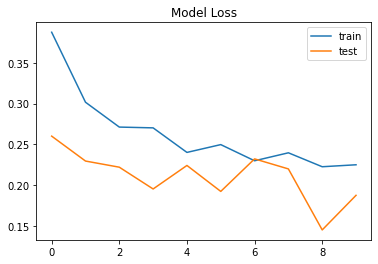

In [ ]:
# plot training history

plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')

plt.title('Model Loss')

plt.legend()
plt.show()

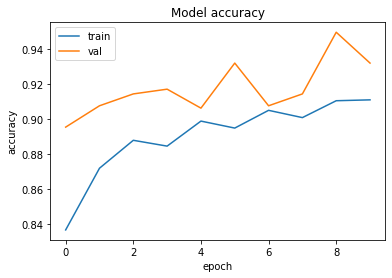

In [ ]:

#You can plot training/validation loss using history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##2. Part-B:att Multi-Label Classification

Some classification tasks require predicting more than one class label. This means that class labels or class membership are not mutually exclusive.

In this part, you'll modify the model to generate predictions for not only the Gender attribute but all 10 attributes at once given an image from the dataset.

Multi-label classification can be supported simply by specifying the # of attributes as the # of nodes in the output layer (i.e 10 attributes -> 10 output nodes). Follow the slides for the appropriate activation and loss functions.

Since the training objective is changed, fine-tuning is needed again.



##2.1) Preparing the Dataset

In [ ]:
face_data = data[['image_id', 'Male',	'Blond_Hair',	'Eyeglasses',	'Wearing_Earrings',	'Bangs'	,'Young',	'Smiling',	'Heavy_Makeup',	'Straight_Hair',	'Black_Hair']].copy()
face_data.head()

,image_id,Male,Blond_Hair,Eyeglasses,Wearing_Earrings,Bangs,Young,Smiling,Heavy_Makeup,Straight_Hair,Black_Hair
0,000001.jpg,0,0,0,1,0,1,1,1,1,0
1,000002.jpg,0,0,0,0,0,1,1,0,0,0
2,000003.jpg,1,0,0,0,0,1,0,0,0,0
3,000004.jpg,0,0,0,1,0,1,0,0,1,0
4,000005.jpg,0,0,0,0,0,1,0,1,0,0


In [ ]:
batch_size = 16
img_h = 128
img_w = 128

#FOLDER_PATH = Enter the path of the folder that contains images
FOLDER_PATH = "/content/data/celeba_30k"


#shuffle the data
data = data.sample(frac=1)
data.reset_index(drop = True, inplace = True)


# Should augmentations be the same for training and validation?  
# No, we just do aug on training data to help model generalaize better on data set

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_aug.flow_from_dataframe(
    dataframe=data[:24000],
    directory=FOLDER_PATH,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    x_col='image_id',
    y_col= ['Male',	'Blond_Hair',	'Eyeglasses',	'Wearing_Earrings',	'Bangs'	,'Young',	'Smiling',	'Heavy_Makeup',	'Straight_Hair',	'Black_Hair'], 
    class_mode='raw'
)

valid_aug = ImageDataGenerator(rescale=1./255)
valid_generator = valid_aug.flow_from_dataframe(
    dataframe=data[24000:27000],
    directory=FOLDER_PATH,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    x_col='image_id',
    y_col= ['Male',	'Blond_Hair',	'Eyeglasses',	'Wearing_Earrings',	'Bangs'	,'Young',	'Smiling',	'Heavy_Makeup',	'Straight_Hair',	'Black_Hair'], 
    class_mode='raw'
        
)

test_aug = ImageDataGenerator(rescale=1./255)
test_generator = test_aug.flow_from_dataframe(
    dataframe=data[27000:],
    directory=FOLDER_PATH,
    shuffle = False,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    x_col='image_id',
    y_col= ['Male',	'Blond_Hair',	'Eyeglasses',	'Wearing_Earrings',	'Bangs'	,'Young',	'Smiling',	'Heavy_Makeup',	'Straight_Hair',	'Black_Hair'], 
    class_mode='raw'
)

Found 24000 validated image filenames.
Found 3000 validated image filenames.
Found 3000 validated image filenames.



##2.2 Transfer Learning For Multi-Label Image Classification

Select network of your choice for the base model:

- AlexNet, VGG16, ResNet-50,  Inception

In [ ]:

ml_base = VGG16(weights='imagenet', input_shape = (img_h,img_w,3), include_top=False)
ml_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
def multi_label_model(base_model, image_shape=IMG_SIZE):
    
    input_shape = image_shape
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # Forward pass to get the output of the last pooling layer
    x = base_model(inputs)

    #Flatten the output
    x = Flatten(name='flatten')(x)    
    
    # Define the new multi label classification head 
    x = Dense(256, activation='relu')(x)    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x) 
    outputs = tf.keras.layers.Dense(10, activation='sigmoid')(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
#Initialize the model
model = multi_label_model(ml_base, (128,128,3))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_11 (Dense)            (None, 256)               2097408   
                                                                 
 activation_5 (Activation)   (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 10)                2570      
                                                                 
Total params: 16,814,666
Trainable params: 16,814,666
Non-t

## Fine-Tune then Train with the Tuned Parameters

In [ ]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.005, decay=1e-6, momentum=0.9, nesterov=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=sgd , metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

history = model.fit(
	train_generator,
	validation_steps = len(valid_generator.filenames)//32, 
  steps_per_epoch= len(train_generator.filenames)//32,
  validation_data=valid_generator,
	epochs = 10,
  workers = 8,
  batch_size = 32,
  #callbacks=[reduce_lr]
  )
# model.load_weights("weights.hdf5")


Epoch 1/10
375/375 [==============================] - 35s 91ms/step - loss: 0.3494 - accuracy: 0.4647 - val_loss: 0.2484 - val_accuracy: 0.5340
Epoch 2/10
375/375 [==============================] - 35s 92ms/step - loss: 0.2651 - accuracy: 0.5042 - val_loss: 0.2372 - val_accuracy: 0.5136
Epoch 3/10
375/375 [==============================] - 35s 91ms/step - loss: 0.2421 - accuracy: 0.5005 - val_loss: 0.2231 - val_accuracy: 0.4715
Epoch 4/10
375/375 [==============================] - 35s 93ms/step - loss: 0.2302 - accuracy: 0.5067 - val_loss: 0.2060 - val_accuracy: 0.5652
Epoch 5/10
375/375 [==============================] - 35s 92ms/step - loss: 0.2239 - accuracy: 0.5017 - val_loss: 0.2073 - val_accuracy: 0.4783
Epoch 6/10
375/375 [==============================] - 37s 98ms/step - loss: 0.2168 - accuracy: 0.5205 - val_loss: 0.2069 - val_accuracy: 0.4538
Epoch 7/10
375/375 [==============================] - 35s 93ms/step - loss: 0.2087 - accuracy: 0.5257 - val_loss: 0.2059 - val_accuracy:

## 6) Test your classifier on Test set

- Apply same pre-processing as training data (Do not pre-processing with data augmentation here, pre-processing refers to operations like resizing, normalization)
- Predict the labels of testing data **using the best model that you have selected according to your validation results** and report the accuracy. 
- Construct a csv file with test predictions and submit it to SuCourse.

Please name the first column image_name and keep the name of the attributes as it is. (Do not change the order of the attributes). Name this file **submission.csv**

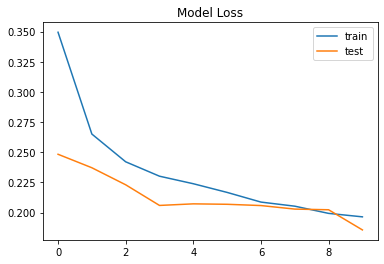

In [ ]:
# Predict
out = model.predict(test_generator) 

# Report your result
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.legend()
plt.show()


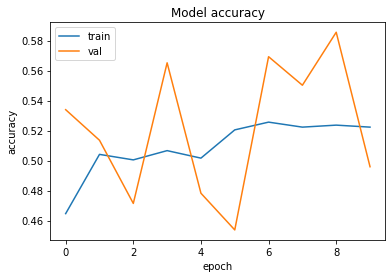

In [ ]:
# Plot Accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Saving prediction with labels to CSV file

In [ ]:
clm = ['Male',	'Blond_Hair',	'Eyeglasses',	'Wearing_Earrings',	'Bangs'	,'Young',	'Smiling',	'Heavy_Makeup',	'Straight_Hair',	'Black_Hair']

labeledOut = []

for item in out:
  x = [] 
  for i in range(10):
    if (item[i] >= 0.5):
      x.append(clm[i])
    else:
      x.append('No_'+clm[i])
    labeledOut.append(x)
    
prediction = pd.DataFrame(labeledOut, columns=clm).to_csv('/content/drive/MyDrive/Colab-Notebooks/Deep learning/HW3/submission.csv')

labeledOut[0:5]


[['No_Male',
  'No_Blond_Hair',
  'No_Eyeglasses',
  'No_Wearing_Earrings',
  'No_Bangs',
  'Young',
  'No_Smiling',
  'Heavy_Makeup',
  'No_Straight_Hair',
  'No_Black_Hair'],
 ['No_Male',
  'No_Blond_Hair',
  'No_Eyeglasses',
  'No_Wearing_Earrings',
  'No_Bangs',
  'Young',
  'No_Smiling',
  'Heavy_Makeup',
  'No_Straight_Hair',
  'No_Black_Hair'],
 ['No_Male',
  'No_Blond_Hair',
  'No_Eyeglasses',
  'No_Wearing_Earrings',
  'No_Bangs',
  'Young',
  'No_Smiling',
  'Heavy_Makeup',
  'No_Straight_Hair',
  'No_Black_Hair'],
 ['No_Male',
  'No_Blond_Hair',
  'No_Eyeglasses',
  'No_Wearing_Earrings',
  'No_Bangs',
  'Young',
  'No_Smiling',
  'Heavy_Makeup',
  'No_Straight_Hair',
  'No_Black_Hair'],
 ['No_Male',
  'No_Blond_Hair',
  'No_Eyeglasses',
  'No_Wearing_Earrings',
  'No_Bangs',
  'Young',
  'No_Smiling',
  'Heavy_Makeup',
  'No_Straight_Hair',
  'No_Black_Hair']]